# Control Contraction Metrics-based Trajectory Stabilization

In [ ]:
# python libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# pydrake imports
from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)
import pydrake.symbolic as sym

# underactuated imports
from underactuated import plot_2d_phase_portrait

# increase default size matplotlib figures
from matplotlib import rcParams
plt.rcParams.update({'font.size': 18})

In [ ]:
%env MOSEKLM_LICENSE_FILE = "mosek.lic"
from pydrake.solvers.mosek import MosekSolver
from pydrake.solvers.snopt import SnoptSolver
from pydrake.solvers.ipopt import IpoptSolver

env: MOSEKLM_LICENSE_FILE="mosek.lic"


# Double Integrator Example

In [ ]:
def CCM_lin(A, B):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    # A = np.array([[-1.0, 0.0], [0.0, -1.0]])
    # f = A.dot(x) + B

    W_poly_deg = 0
    W_11 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_12 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_22 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()

    W = np.array([[W_11, W_12], [W_12, W_22]])

    rho = prog.NewContinuousVariables(1, "rho")[0]
    R = W.dot(A.transpose()) + A.dot(W) - rho*B.dot(B.transpose())

    y = prog.NewIndeterminates(2, "y")
    P_W = y.dot(W).dot(y)
    P_R = -y.dot(R).dot(y)

    eps = 1e-4
    lam = 1
    prog.AddSosConstraint(P_W - eps*y.dot(y))
    prog.AddSosConstraint(P_R - eps*y.dot(y) - 2*lam*y.dot(W).dot(y))
    prog.AddConstraint(rho >= 0)

    # prog.AddCost(-rho)
    prog.AddCost(0)

    # print(prog)
    solver = MosekSolver()
    result = solver.Solve(prog)
    if result.is_success:
        print("success")
        print(result)
        # print(result.GetSolution(W))
        # print(result.GetSolution(R))
        print(result.GetSolution(rho))
        return result.GetSolution(W), result.GetSolution(rho)
    else:
        print("Could not find a contraction metric")

In [ ]:
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0., 1.]])
W_lin, rho_lin = CCM_lin(A, B)
W_lin = np.array([[0.41236594600738113, 0.52350055808337315], [0.52350055808337315, 0.98477411982242202]])

success
2.368888277612993


In [ ]:
def min_time_double_int(t, x):
    dfdx = np.zeros((2))
    if x[0] == 0 and x[1] == 0:
        u = 0
    elif (x[1] < 0 and x[0] <= 1/2*x[1]**2) or (x[1] >= 0 and x[0] < -1/2*x[1]**2):
        u = 1
    else:
        u = -1
    
    dfdx[0] = x[1]
    dfdx[1] = u
    return dfdx

In [ ]:
sol_1 = solve_ivp(min_time_double_int, [0, 5], [-2, 0], t_eval = np.linspace(0, 5, 51))
# sol_2 = solve_ivp(stable_lin, [0, 2], [20, 30], t_eval = np.linspace(0, 2, 51))
# print(sol_1.t)
# print(sol_1.y[0])
print(np.shape(sol_1.y)[1])

51


In [ ]:
def CCM_double_int_control(t, x):
    dfdx = np.zeros((4))
    if x[0] == 0 and x[1] == 0:
        u_ref = 0
    elif (x[1] < 0 and x[0] <= 1/2*x[1]**2) or (x[1] >= 0 and x[0] < -1/2*x[1]**2):
        u_ref = 1
    else:
        u_ref = -1
    
    dfdx[0] = x[1]
    dfdx[1] = u_ref

    B = np.array([[0.], [1.]])
    x_diff = np.array([[x[2]-x[0]], [x[3]-x[1]]])
    u_CCM = u_ref - 1/2*rho_lin*B.transpose().dot(np.linalg.inv(W_lin)).dot(x_diff)
    dfdx[2] = x[3]
    dfdx[3] = u_CCM
    return dfdx

In [ ]:
sol = solve_ivp(CCM_double_int_control, [0, 4], [-1, 0, -1.1, 0], t_eval = np.linspace(0, 4, 51))

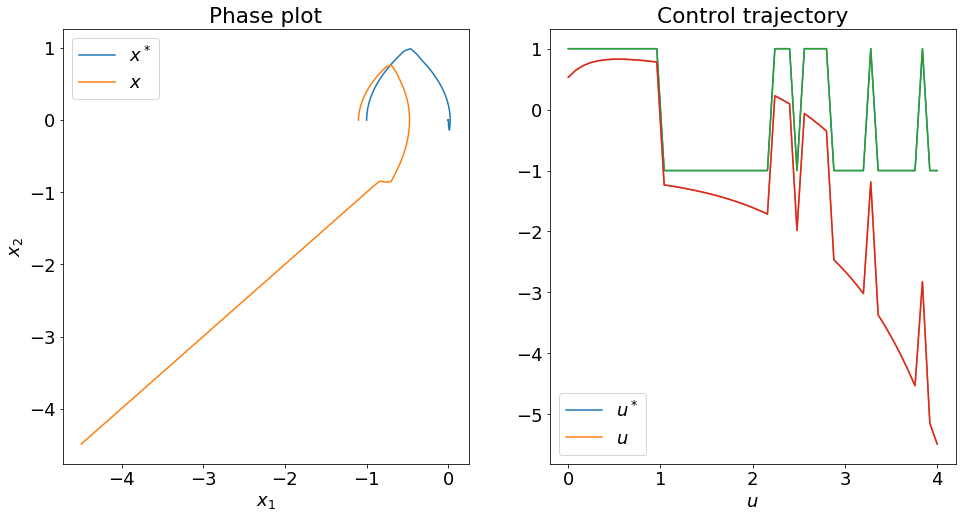

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Create a figure containing a single axes.
# ax[0].plot(sol.t, sol.y[0])  # Plot some data on the axes.
# ax[0].plot(sol.t, sol.y[2])
p1, = ax[0].plot(sol.y[0], sol.y[1])
p2, = ax[0].plot(sol.y[2], sol.y[3])
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[0].title.set_text('Phase plot')
ax[0].legend([p1, p2], [r'$x^*$', r'$x$'])


N = sol.t.shape[0]
u_ref = np.zeros((N, ))
u_CCM = np.zeros((N, ))
for i in range(N):
    if sol.y[0, i] == 0 and sol.y[1, i] == 0:
        u_ref[i] = 0
    elif (sol.y[1, i] < 0 and sol.y[0, i] <= 1/2*sol.y[1, i]**2) or (sol.y[1, i] >= 0 and sol.y[0, i] < -1/2*sol.y[1, i]**2):
        u_ref[i] = 1
    else:
        u_ref[i] = -1
    
    B = np.array([[0.], [1.]])
    x_diff = np.array([[sol.y[2, i]-sol.y[0, i]], [sol.y[3, i]-sol.y[1, i]]])
    u_CCM[i] = u_ref[i] - 1/2*rho_lin*B.transpose().dot(np.linalg.inv(W_lin)).dot(x_diff)

ax[1].plot(sol.t, u_ref)
ax[1].plot(sol.t, u_CCM)
ax[1].plot(sol.t, u_ref)
ax[1].plot(sol.t, u_CCM)
ax[1].set_xlabel(r"t [sec]")
ax[1].set_xlabel(r"$u$")
ax[1].title.set_text('Control trajectory')
ax[1].legend([r'$u^*$', r'$u$'])

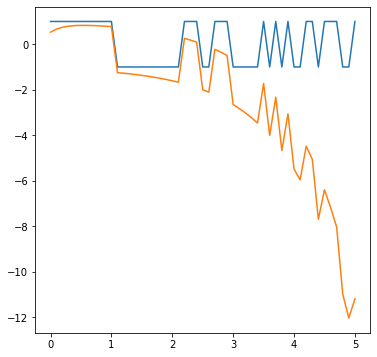

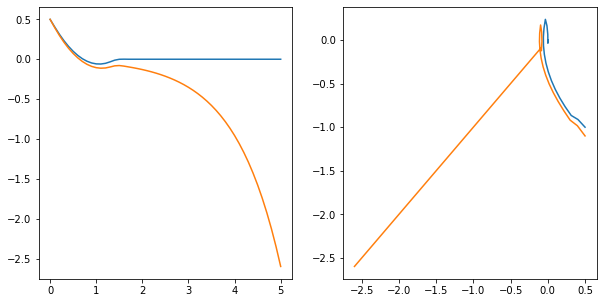

In [ ]:
sol = solve_ivp(CCM_double_int_control, [0, 3], [1/2, -1, 1/2, -1.1], t_eval = np.linspace(0, 5, 51))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure containing a single axes.
ax[0].plot(sol.t, sol.y[0])  # Plot some data on the axes.
ax[0].plot(sol.t, sol.y[2])
ax[1].plot(sol.y[0], sol.y[1])
ax[1].plot(sol.y[2], sol.y[3])
# ax[1].plot(sol_2.y[0], sol_2.y[1])

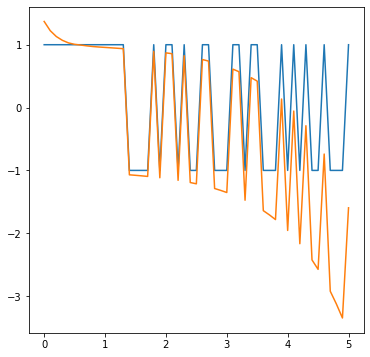

In [ ]:
N = sol.t.shape[0]
u_ref = np.zeros((N, ))
u_CCM = np.zeros((N, ))
for i in range(N):
    if sol.y[0, i] == 0 and sol.y[1, i] == 0:
        u_ref[i] = 0
    elif (sol.y[1, i] < 0 and sol.y[0, i] <= 1/2*sol.y[1, i]**2) or (sol.y[1, i] >= 0 and sol.y[0, i] < -1/2*sol.y[1, i]**2):
        u_ref[i] = 1
    else:
        u_ref[i] = -1
    
    B = np.array([[0.], [1.]])
    x_diff = np.array([[sol.y[2, i]-sol.y[0, i]], [sol.y[3, i]-sol.y[1, i]]])
    u_CCM[i] = u_ref[i] - 1/2*rho_lin*B.transpose().dot(np.linalg.inv(W_lin)).dot(x_diff)

fig, ax = plt.subplots()
ax.plot(sol.t, u_ref)
ax.plot(sol.t, u_CCM)

Now we try a linear system with smooth optimal feedback controller

# Polynomial System Example 1

In [ ]:
def CCM_poly():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = np.array([[-x[0] - x[0]**3 + x[1]**2], [0.]])
    B = np.array([[0.], [1.]])

    W_poly_deg = 0
    W_11 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_12 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_22 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()

    W = np.array([[W_11, W_12], [W_12, W_22]])
    # W_11_dot = W_11.Jacobian(x).dot(f)
    # W_12_dot = W_12.Jacobian(x).dot(f)
    # W_22_dot = W_22.Jacobian(x).dot(f)
    # W_dot = np.array([[M_11_dot, M_12_dot], [M_12_dot, M_22_dot]])

    dfdx = np.array([[-1. - 3*x[0]**2, 2*x[1]], [0., 0.]])

    rho_deg = 2
    rho = prog.NewSosPolynomial(Variables(x), rho_deg)[0].ToExpression()
    lam = 0.2
    R = W.dot(dfdx.transpose()) + dfdx.dot(W) + 2*lam*W - rho*B.dot(B.transpose())

    y = prog.NewIndeterminates(2, "y")
    P_W = y.dot(W).dot(y)
    P_R = -y.dot(R).dot(y)

    eps = 1e-3
    prog.AddSosConstraint(P_W - eps*y.dot(y))
    prog.AddSosConstraint(P_R - eps*y.dot(y))
    # prog.AddSosConstraint(P_R - eps*y.dot(y) - 2*lam*y.dot(M).dot(y))

    a1 = prog.NewContinuousVariables(1, "a1")[0]
    a2 = prog.NewContinuousVariables(1, "a2")[0]
    prog.AddSosConstraint(y.dot(W - a1*np.eye(2)).dot(y))
    prog.AddSosConstraint(y.dot(a2*np.eye(2) - W).dot(y))

    prog.AddLinearCost(- a1)
    prog.AddLinearConstraint(a1 >= 1e-4)

    # print(prog)
    solver = MosekSolver()
    result = solver.Solve(prog)
    if result.is_success:
        # print("success")
        # print(result)
        # print(result.GetSolution(W))
        # print(result.GetSolution(R))
        return result.GetSolution(W), result.GetSolution(rho)
    else:
        print("Could not find a contraction metric")

In [ ]:
W_poly, rho_poly = CCM_poly()
print(W_poly)
print(rho_poly)

[[<Expression "0.4601548932303664"> <Expression "0">]
 [<Expression "0"> <Expression "0.34034624553666376">]]
(1.0723819685260756 - 4.3166115015470023e-26 * x(0) + 1.5688318928454115e-33 * x(1) - 3.1343613908899899e-17 * (x(0) * x(1)) + 0.99999999999999967 * pow(x(0), 2) + 1.406618884950928 * pow(x(1), 2))


In [ ]:
def CCM_poly_func():
    W = np.array([[0.4601548932303664, 0.], [0., 0.34034624553666376]])
    M = np.linalg.inv(W)
    rho = lambda x: 1.0723819685260756 + x[0]**2 + 1.406618884950928*x[1]**2
    return M, rho

In [ ]:
M_poly, rho_poly = CCM_poly_func()

In [ ]:
def poly_sys_ref(t, x):
    dfdx = np.zeros((2, ))
    u_ref = -x[0]*x[1] - x[1]
    dfdx[0] = -x[0] - x[0]**3 + x[1]**2
    dfdx[1] = u_ref
    return dfdx

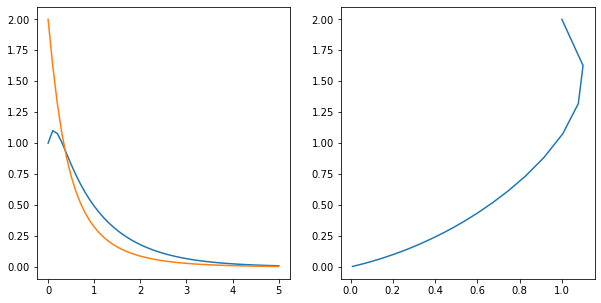

In [ ]:
sol = solve_ivp(poly_sys_ref, [0, 5], [1., 2.], t_eval = np.linspace(0, 5, 51))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol.t, sol.y[0])
ax[0].plot(sol.t, sol.y[1])
ax[1].plot(sol.y[0], sol.y[1])

In [ ]:
def poly_sys_control(t, x):
    dfdx = np.zeros((4, ))

    u_ref = -x[0]*x[1] - x[1]
    dfdx[0] = -x[0] - x[0]**3 + x[1]**2
    dfdx[1] = u_ref

    B = np.array([[0.], [1.]])

    du = 0.
    N = 10
    S = np.zeros((2, N+1))
    rho = np.zeros((N))
    S[:, 0] = x[0: 2]
    S[:, -1] = x[2: ]
    x_diff = x[2: ] - x[0: 2]
    for i in range(N):
        S[:, i+1] = x[0: 2] + x_diff/N*(i+1)
        rho[i] = rho_poly(S[:, i])
        dx = S[:, i+1] - S[:, i]
        du = -1/2*rho[i]*B.transpose().dot(M_poly).dot(dx) + du

    u_CCM = u_ref + du
    # print("compute du")
    dfdx[2] = -x[2] - x[2]**3 + x[3]**2
    dfdx[3] = u_CCM
    # dfdx[3] = 0
    return dfdx

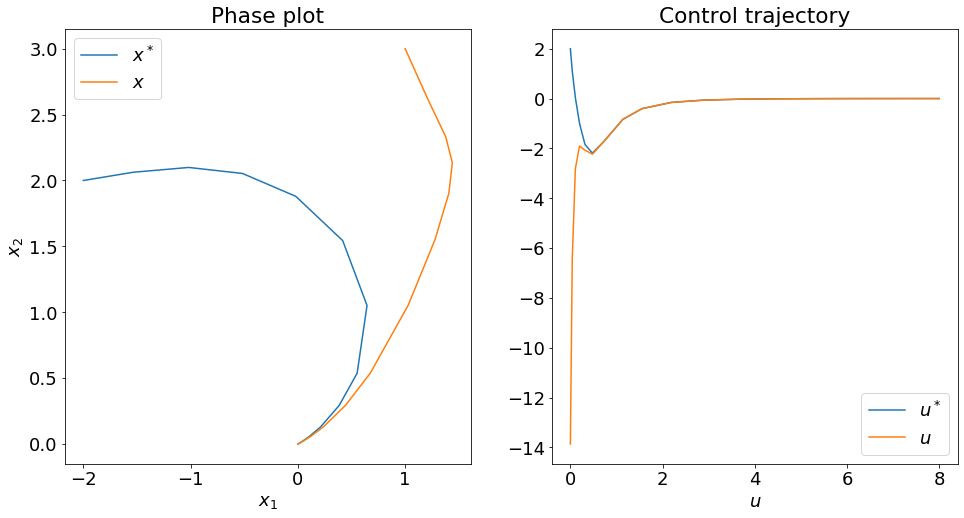

In [ ]:
# sol_sim = solve_ivp(poly_sys_control, [0, 5], [1., 2., 4., 2.])
sol_sim = solve_ivp(poly_sys_control, [0, 8], [-2., 2., 1., 3.])
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# ax[0].plot(sol_sim.t, sol_sim.y[0])
# ax[0].plot(sol_sim.t, sol_sim.y[2])
p1, = ax[0].plot(sol_sim.y[0], sol_sim.y[1])
p2, = ax[0].plot(sol_sim.y[2], sol_sim.y[3])
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[0].title.set_text('Phase plot')
ax[0].legend([p1, p2], [r'$x^*$', r'$x$'])

sol = sol_sim
N_sim = sol.t.shape[0]
u_ref = np.zeros((N_sim, ))
u_CCM = np.zeros((N_sim, ))
for i in range(N_sim):
    u_ref[i] = -sol.y[0, i]*sol.y[1, i] - sol.y[1, i]
    
    B = np.array([[0.], [1.]])
    du = 0.
    N = 10
    S = np.zeros((2, N+1))
    rho = np.zeros((N, ))
    S[:, 0] = sol.y[0: 2, i]
    S[:, -1] = sol.y[2: , i]
    x_diff = sol.y[2: , i] - sol.y[0: 2, i]
    for j in range(N):
        S[:, j+1] = sol.y[0: 2, i] + x_diff/N*(j+1)
        rho[j] = rho_poly(S[:, j])
        dx = S[:, j+1] - S[:, j]
        du = -1/2*rho[j]*B.transpose().dot(M_poly).dot(dx) + du
    
    u_CCM[i] = u_ref[i] + du

ax[1].plot(sol.t, u_ref)
ax[1].plot(sol.t, u_CCM)
ax[1].set_xlabel(r"t [sec]")
ax[1].set_xlabel(r"$u$")
ax[1].title.set_text('Control trajectory')
ax[1].legend([r'$u^*$', r'$u$'])


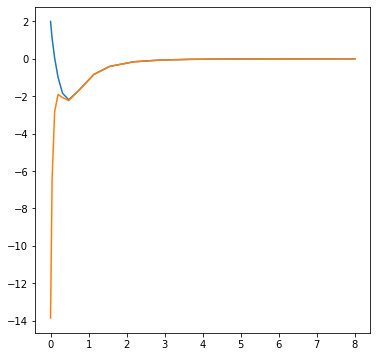

# Polynomial System Example 2

In [ ]:
def CCM_poly_2():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(3, "x")
    # xm = sym.GetVariableVector(x[0: 2])
    # print(xm)
    # xm = xm.ToExpression()
    f = np.array([[-x[0] + x[2]], [x[0]**2 - x[1] - 2*x[0]*x[2] + x[2]], [-x[1]]])
    B = np.array([[0.], [0.], [1.]])

    W_poly_deg = 2

    W_11 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_12 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_13 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_22 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_23 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()
    W_33 = prog.NewFreePolynomial(Variables(x), W_poly_deg).ToExpression()

    W = np.array([[W_11, W_12, W_13], [W_12, W_22, W_23], [W_13, W_23, W_33]])
    W_11_dot = W_11.Jacobian(x).dot(f)
    W_12_dot = W_12.Jacobian(x).dot(f)
    W_13_dot = W_13.Jacobian(x).dot(f)
    W_22_dot = W_22.Jacobian(x).dot(f)
    W_23_dot = W_23.Jacobian(x).dot(f)
    W_33_dot = W_33.Jacobian(x).dot(f)
    W_dot = np.array([[W_11_dot, W_12_dot, W_13_dot], [W_12_dot, W_22_dot, W_23_dot], [W_13_dot, W_23_dot, W_33_dot]])

    W_dot = W_dot[:, :, 0]
    # print(W_dot)
    dfdx = np.array([[-1., 0., 1.], [2*x[0] - 2*x[2], -1., -2*x[0] + 1], [0., -1., 0.]])

    rho_deg = 2
    # x_rho = x[0]
    rho = prog.NewSosPolynomial(Variables(x), rho_deg)[0].ToExpression()
    lam = 0.5
    R = -W_dot + W.dot(dfdx.transpose()) + dfdx.dot(W) + 2*lam*W - rho*B.dot(B.transpose())
    # R = W.dot(dfdx.transpose()) + dfdx.dot(W) + 2*lam*W - rho*B.dot(B.transpose())

    y = prog.NewIndeterminates(3, "y")
    P_W = y.dot(W).dot(y)
    P_R = -y.dot(R).dot(y)

    eps = 1e-3
    prog.AddSosConstraint(P_W - eps*y.dot(y))
    prog.AddSosConstraint(P_R - eps*y.dot(y))

    W_x_11 = W_11.Jacobian(x)
    W_x_12 = W_12.Jacobian(x)
    W_x_13 = W_13.Jacobian(x)
    W_x_22 = W_22.Jacobian(x)
    W_x_23 = W_23.Jacobian(x)
    W_x_33 = W_33.Jacobian(x)

    prog.AddSosConstraint(W_x_11[2])
    prog.AddSosConstraint(W_x_12[2])
    prog.AddSosConstraint(W_x_13[2])
    prog.AddSosConstraint(W_x_22[2])
    prog.AddSosConstraint(W_x_23[2])
    prog.AddSosConstraint(W_x_33[2])

    prog.AddSosConstraint(-W_x_11[2])
    prog.AddSosConstraint(-W_x_12[2])
    prog.AddSosConstraint(-W_x_13[2])
    prog.AddSosConstraint(-W_x_22[2])
    prog.AddSosConstraint(-W_x_23[2])
    prog.AddSosConstraint(-W_x_33[2])

    a1 = prog.NewContinuousVariables(1, "a1")[0]
    a2 = prog.NewContinuousVariables(1, "a2")[0]
    prog.AddSosConstraint(y.dot(W - a1*np.eye(3)).dot(y))
    prog.AddSosConstraint(y.dot(a2*np.eye(3) - W).dot(y))

    prog.AddLinearCost(a2 - a1)
    prog.AddLinearConstraint(a1 >= 1e-4)

    # print(prog)
    solver = MosekSolver()
    result = solver.Solve(prog)
    if result.is_success:
        # print("success")
        # print(result)
        # print(result.GetSolution(W))
        # print(result.GetSolution(R))
        return result.GetSolution(W), result.GetSolution(rho)
    else:
        print("Could not find a contraction metric")

In [ ]:
W_poly_2, rho_poly_2 = CCM_poly_2()
print(W_poly_2)
print(rho_poly_2)

[[<Expression "(0.0010453741122844788 + 1.9890682055844446e-06 * x(0) + 6.9920618864482672e-06 * x(1) + 6.761529208857957e-07 * x(2) - 1.7537937514160989e-06 * pow(x(0), 2))">
  <Expression "(0.00031965326243623928 - 0.00083887472603368248 * x(0) + 1.5851003687041367e-06 * x(1) + 8.6359545934148428e-06 * x(2) - 1.7537937514160989e-06 * (x(0) * x(1)) - 3.6822534394032537e-07 * pow(x(0), 2))">
  <Expression "(-0.00052812794536035118 - 6.9105166379226741e-06 * x(0) - 4.7230269908162588e-06 * x(1) - 1.255296417457461e-06 * x(2) - 8.7689687570804947e-07 * pow(x(0), 2))">]
 [<Expression "(0.00031965326243623928 - 0.00083887472603368248 * x(0) + 1.5851003687041367e-06 * x(1) + 8.6359545934148428e-06 * x(2) - 1.7537937514160989e-06 * (x(0) * x(1)) - 3.6822534394032537e-07 * pow(x(0), 2))">
  <Expression "(0.51154888553923139 + 1.2551582572186102e-05 * x(0) - 0.0015779469003529792 * x(1) - 7.8081895187747871e-08 * x(2) - 7.3645068788065074e-07 * (x(0) * x(1)) + 1.9122793578527583e-06 * pow(x(0)

In [ ]:
def CCM_poly_2_func():
    W = lambda x: np.array([[0.0010453741122844788, 
        0.00031965326243623928 - 0.00083887472603368248 * x[0], 
        -0.00052812794536035118],
        [0.00031965326243623928 - 0.00083887472603368248 * x[0], 
        0.51154888553923139 + 1.2551582572186102e-05 * x[0] - 0.0015779469003529792 * x[1], 
        0.51154888553923139 + 1.2551582572186102e-05 * x[0] - 0.0015779469003529792 * x[1]],
        [-0.00052812794536035118, 
        0.00074100354279452076 + 0.0004571055822045326 * x[0], 
        0.37902419899190581]
    ])
    rho = lambda x: 4514.7811577114162 - 189.03156317568613 * x[0] + 1.8587006056756321 * x[1]- 46.52064745332018 * x[2] - 3.6749264022911836 * (x[0] * x[1]) + 6.2813263272870659 * (x[0] * x[2]) - 0.68511334464405615 * (x[1] * x[2]) + 4460.0621302205163 * pow(x[0], 2) + 4463.0098085384634 * pow(x[1], 2) + 4453.8606668846123 * pow(x[2], 2)
    return W, rho

In [ ]:
W_poly_2, rho_poly_2 = CCM_poly_2_func()

In [ ]:
def optimal_poly_2(x0, dt, N):
    prog = MathematicalProgram()
    Q = np.eye(3)
    R = 0.1

    x = prog.NewContinuousVariables(3, N+1, 'state')
    u = prog.NewContinuousVariables(N, 'control')

    residual_0 = (x[:, 0] - x0).dot(x[:, 0] - x0)
    prog.AddConstraint(residual_0 == 0)

    for i in range(N):
        xdot_i = np.array([-x[0, i] + x[2, i],
                        x[0, i]**2 - x[1, i] - 2*x[0, i]*x[2, i] + x[2, i],
                        -x[1, i] + u[i]])
        residual_i = x[:, i+1] - xdot_i*dt - x[:, i]
        # print(residual_i)
        for j in range(3):
            residual_j = residual_i[j]
            prog.AddConstraint(residual_j == 0)

        prog.AddCost(x[:, i+1].dot(Q).dot(x[:, i+1]))
        prog.AddCost(R*u[i]*u[i])
    
    solver = SnoptSolver()

    result = solver.Solve(prog)
    if result.is_success:
        # print("success")

        return result.GetSolution(x), result.GetSolution(u)
    else:
        print("Optimization failed")

In [ ]:
x0 = np.array([1., 1., 1.])
dt = 0.1
N = 40
x_opt, u_opt = optimal_poly_2(x0, dt, N)

In [ ]:
def compute_geodesic_poly_2(x1, x2, W_poly_2, N_seg):
    prog = MathematicalProgram()
    S = prog.NewContinuousVariables(3, N_seg-1, 's_i')

    eps = 1e-6

    ds_i = S[:, 0] - x1
    M_s_i = W_poly_2(x1 + ds_i/2).inv()
    D_i = ds_i.dot(M_s_i).dot(ds_i)
    prog.AddCost(D_i)

    for i in range(N_seg-2):
        ds_i = S[:, i+1] - S[:, i]
        M_s_i = W_poly_2(S[:, i] + ds_i/2).inv()
        D_i = ds_i.dot(M_s_i).dot(ds_i)
        prog.AddCost(D_i)
    
    ds_i = x2 - S[:, N_seg-2]
    M_s_i = W_poly_2(S[:, N_seg-2] + ds_i/2).inv()
    D_i = ds_i.dot(M_s_i).dot(ds_i)
    prog.AddCost(D_i)

    # Set an initial guess as equally distanced points in between
    S_0 = np.zeros((2, N_seg-1))
    for i in range(N_seg-1):
        S_0[:, i] = x1 + (x2 - x1)*(i+1)/N_seg

    solver = SnoptSolver()
    result = solver.Solve(prog)
    if result.is_success():
        S_opt = result.GetSolution(S)
        cost = result.get_optimal_cost()
        return [S_opt, cost]
    else:
        print("result wrong:")
        print(x1, x2)
        return[S_opt, cost]

In [ ]:
def poly_2_sim(x0_CCM, dt, N, W_poly_2, rho_poly_2, N_seg, x_opt, u_opt):
    x_CCM = np.zeros((3, N+1))
    u_CCM = np.zeros(N, )
    B = np.array([[0.], [0.], [1.]])

    x_CCM[:, 0] = x0_CCM
    for i in range(N):
        x1 = x_opt[:, i]
        x2 = x_CCM[:, i]
        S_i = compute_geodesic_poly_2(x1, x2, W_poly_2, N_seg)

        ds_j = S[:, 0] - x1
        M_s_j = np.linalg.inv(W_poly_2(x1 + ds_j/2) + eps*np.eye(3))
        du = -1/2*rho_poly_2(x1 + ds_j/2)*B.transpose().dot(M_s_j)
        for j in range(N_seg-2):
            ds_j = S[:, j+1] - S[:, j]
            M_s_j = np.linalg.inv(W_poly_2(S[:, j] + ds_j/2) + eps*np.eye(3))
            du = du - 1/2*rho_poly_2(S[:, j] + ds_j/2)*B.transpose().dot(M_s_j) 

        ds_j = x2 - S[:, N_seg-2]
        M_s_j = np.linalg.inv(W_poly_2(S[:, N_seg-2] + ds_j/2) + eps*np.eye(3))
        du = du - 1/2*rho_poly_2(S[:, N_seg-2] + ds_j/2)*B.transpose().dot(M_s_j) 

        u_CCM[i] = u_opt[i] + du
        xdot_i = np.array([-x_CCM[0, i] + x_CCM[2, i],
                        x_CCM[0, i]**2 - x_CCM[1, i] - 2*x_CCM[0, i]*x_CCM[2, i] + x_CCM[2, i],
                        -x_CCM[1, i] + u_CCM[i]])
        x_CCM[:, i+1] = xdot_i*dt + x_CCM[:, i]
    
    return x_CCM, u_CCM

In [ ]:
def poly_2_euc_curve_sim(x0_CCM, dt, N, W_poly_2, rho_poly_2, N_seg, x_opt, u_opt):
    x_CCM = np.zeros((3, N+1))
    u_CCM = np.zeros(N, )
    B = np.array([[0.], [0.], [1.]])

    x_CCM[:, 0] = x0_CCM
    for i in range(N):
        x1 = x_opt[:, i]
        x2 = x_CCM[:, i]
        du = 0

        for j in range(N_seg):
            dx_j = (x2 - x1)/N_seg
            s_j = x1 + dx_j*j/N_seg
            M_s_j = np.linalg.inv(W_poly_2(s_j) + 1e-6*np.eye(3))
            du = du -1/2*rho_poly_2(s_j)*B.transpose().dot(M_s_j).dot(dx_j)

        u_CCM[i] = u_opt[i] + du
        xdot_i = np.array([-x_CCM[0, i] + x_CCM[2, i],
                        x_CCM[0, i]**2 - x_CCM[1, i] - 2*x_CCM[0, i]*x_CCM[2, i] + x_CCM[2, i],
                        -x_CCM[1, i] + u_CCM[i]])
        x_CCM[:, i+1] = xdot_i*dt + x_CCM[:, i]
    
    return x_CCM, u_CCM

In [ ]:
x_CCM, u_CCM = poly_2_euc_curve_sim([2., 2., 2.], dt, N, W_poly_2, rho_poly_2, 2, x_opt, u_opt)
x_CCM

<ipython-input-89-0f29fb0e8a8a>:16: RuntimeWarning: overflow encountered in multiply
  du = du -1/2*rho_poly_2(s_j)*B.transpose().dot(M_s_j).dot(dx_j)
<ipython-input-89-0f29fb0e8a8a>:14: RuntimeWarning: invalid value encountered in multiply
  s_j = x1 + dx_j*j/N_seg
<ipython-input-19-94eab8cb3a5c>:12: RuntimeWarning: invalid value encountered in double_scalars
  rho = lambda x: 4514.7811577114162 - 189.03156317568613 * x[0] + 1.8587006056756321 * x[1]- 46.52064745332018 * x[2] - 3.6749264022911836 * (x[0] * x[1]) + 6.2813263272870659 * (x[0] * x[2]) - 0.68511334464405615 * (x[1] * x[2]) + 4460.0621302205163 * pow(x[0], 2) + 4463.0098085384634 * pow(x[1], 2) + 4453.8606668846123 * pow(x[2], 2)
<ipython-input-89-0f29fb0e8a8a>:20: RuntimeWarning: invalid value encountered in double_scalars
  x_CCM[0, i]**2 - x_CCM[1, i] - 2*x_CCM[0, i]*x_CCM[2, i] + x_CCM[2, i],


array([[ 2.00000000e+000,  2.00000000e+000, -4.23217537e+002,
         1.41296923e+011, -5.18337383e+036,  3.10909648e+113,
                    -inf,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan],
       [ 2.00000000e+000,  1.60000000e+000,  1.27689261e+003,
         1.19739969e+014,  1.46478954e+048,  3.22312186e+150,
                     nan,

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=21c3e526-6092-407b-92b0-f6897737c93c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>